In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import abc
import joypy
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import torch
import typing

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from operator import itemgetter
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from torch import nn
from ttb import Dataset

from lib.model import (
    ClassifierDriftModel,
    ClassifierUncertaintyModel,
    CVMModel,
    FETModel,
    LearnedKernelModel,
    MMDModel,
    ModelWrapperInterface,
    OutputClassifierAccuracyBaselineModel,
    OutputClassifierF1ScoreBaselineModel,
    SpotTheDiffModel,
    TabularModel,
)
from alibi_detect.utils.pytorch.kernels import DeepKernel
from lib.data_aug_utils import (
    dollars_per_mile,
    pickup_day_in_month,
    pickup_day_in_week,
    pickup_month_inc_year,
    pickup_time_sice_midnight,
    tip_percent_column,
)
from lib.data_clean_utils import hard_coded_cleaning_steps_mutation
from lib.data_load_utils import (
    AccessorFactory,
    AnnotatedTrainTestDataFrameAccessor,
    batch_load_df,
    date_iter_step_size,
    TrainTestDataFrameAccessor,
)

In [5]:
global_start_date = datetime.strptime("2020-11-15", "%Y-%m-%d")
global_end_date = datetime.strptime("2021-01-01", "%Y-%m-%d")
dataset = Dataset("taxi_data", cutoff_date=global_end_date, backend="pandas")

# Loading large datasets can cause memory use to spike, so we batch loading here.
df = batch_load_df(dataset, global_start_date, global_end_date, 1, 'tqdm')
hard_coded_cleaning_steps_mutation(df)
df.insert(1, 'pickup_month_inc_year', pickup_month_inc_year(df['tpep_pickup_datetime']))
df.insert(2, 'pickup_day_in_month', pickup_day_in_month(df['tpep_pickup_datetime']))
df.insert(3, 'pickup_mins_since_midnight', pickup_time_sice_midnight(df['tpep_pickup_datetime']))
df.insert(14, 'tip_percent', tip_percent_column(df['total_amount'], df['tip_amount']))
df.insert(15, 'tip_percent_greater_15', df['tip_percent'] > .15)
df.insert(21, 'total_amount_per_mile', dollars_per_mile(df['total_amount'], df['trip_distance']))

df_sample = df.sample(frac=.0005)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\HP\anaconda3\envs\ttb\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
100%|██████████| 1/1 [00:46<00:00, 46.91s/it]


In [6]:
'''
    Some drift detection methods benefit from the knowledge of
    what features are categorical.
'''
is_continuous_annotations = {
    'congestion_surcharge': False,
    'dolocationid': False,
    'extra': False,
    'fare_amount': True,
    'id': False,
    'improvement_surcharge': False,
    'mta_tax': False,
    'passenger_count': False,
    'payment_type': False,
    'pickup_day_in_month': True,
    'pickup_mins_since_midnight': True,
    'pickup_month_inc_year': False,
    'pulocationid': False,
    'ratecodeid': False,
    'store_and_fwd_flag': False,
    'tip_amount': True,
    'tip_percent_greater_15': False,
    'tip_percent': True,
    'tolls_amount': True,
    'total_amount_per_mile': True,
    'total_amount': True,
    'trip_distance': True,
    'vendorid': False,
}

In [7]:
x_labels = [
       'congestion_surcharge',
       'dolocationid',
       'extra',
       'fare_amount',
       'improvement_surcharge',
       'mta_tax',
       'passenger_count',
       'payment_type',
       'pickup_mins_since_midnight',
       'pulocationid',
       'ratecodeid',
       'store_and_fwd_flag',
       'tolls_amount',
       'total_amount_per_mile',
       'total_amount',
       'trip_distance',
       'vendorid',
]
y_label = 'tip_percent_greater_15'

classifier_model = RandomForestClassifier()
classifier_model.fit(df_sample[x_labels], df_sample[y_label])

name_and_importance = list(zip(x_labels, classifier_model.feature_importances_))
name_and_importance.sort(key = itemgetter(1), reverse=True)
for col_name, importance in name_and_importance[:10]:
    print(f"Column {col_name} has importance {importance}")

Column payment_type has importance 0.2960063208140351
Column total_amount has importance 0.1687998908281589
Column total_amount_per_mile has importance 0.1179741944185749
Column trip_distance has importance 0.08283040863279292
Column fare_amount has importance 0.0825911048375515
Column pickup_mins_since_midnight has importance 0.07252801181412957
Column pulocationid has importance 0.059496986688820884
Column dolocationid has importance 0.05789193624889628
Column extra has importance 0.02349043962559546
Column passenger_count has importance 0.01653958057372789


In [8]:
def get_periodic_model_performance(
    df_accessor: TrainTestDataFrameAccessor, 
    model: ModelWrapperInterface) -> np.array:
    '''
        Returns performance list when fitted on Accessor
        fit method and inferred on Accessor iterable.
    '''
    perf_list, _ = get_periodic_model_performance_with_time(
        df_accessor, model)
    return perf_list

def get_periodic_model_performance_with_time(
    df_accessor: TrainTestDataFrameAccessor, 
    model: ModelWrapperInterface) -> tuple[np.array, np.array]:
    '''
        Returns performance list when fitted on Accessor
        fit method and inferred on Accessor iterable.
    '''
    model.fit(*df_accessor.get_xy_fit_np())
    
    perf_list = []
    time_list = []

    for args in df_accessor.get_xy_infer_iterable_np():
        start = time.time()
        perf_list.append(model.infer(*args))
        time_list.append(time.time() - start)
    return np.array(perf_list), np.array(time_list)

In [9]:
def plot_feature_wise_interweek_performance(
    accessor_factory: AccessorFactory,
    model: ModelWrapperInterface,
    y_label: str):
    fig, axs = plt.subplots(5, 5, figsize=(25,17))
    strftime_rep = '%Y-%m-%d'

    for ax, col_name in zip(axs.reshape(-1), df_data.columns):
        df_accessor = accessor_factory.get((col_name,), y_label)
        drifts_arr = get_periodic_model_performance(df_accessor, model)
        
        # Can't see 0 or 1 on graph if (0,1)
        ax.set_ylim((-.1, 1.1))
        ax.title.set_text(f'Feature Drift for {col_name}')
        ax.set_ylabel('P-val for No Drift')
        ax.set_xlabel(f'Weeks since {df_accessor.get_fit_dates()[0].strftime(strftime_rep)}')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.plot(range(1, drifts_arr.size + 1), drifts_arr)
    fig.tight_layout()

def get_drift_perf(
    accessor_factory: AccessorFactory,
    model: ModelWrapperInterface,
    x_labels: tuple[str, ...],
    y_label: str) -> np.array:

    df_accessor = accessor_factory.get(x_labels, y_label)
    return get_periodic_model_performance(df_accessor, model)

def get_drift_perf_with_runtimes(
    accessor_factory: AccessorFactory,
    model: ModelWrapperInterface,
    x_labels: tuple[str, ...],
    y_label: str) -> np.array:

    df_accessor = accessor_factory.get(x_labels, y_label)
    return get_periodic_model_performance_with_time(
        df_accessor, model)


def create_df_model_performance(
    model_name: str,
    model_perf: np.array,
    date_slices: tuple[datetime, datetime]) -> pd.DataFrame:

    strftime_rep = '%Y-%m-%d'
    start_dates = (start_date for start_date, _ in date_slices)

    date_dict = {start_date.strftime(strftime_rep): perf for start_date, perf in zip(start_dates, model_perf)}
    return pd.DataFrame(date_dict, index=[model_name])
    


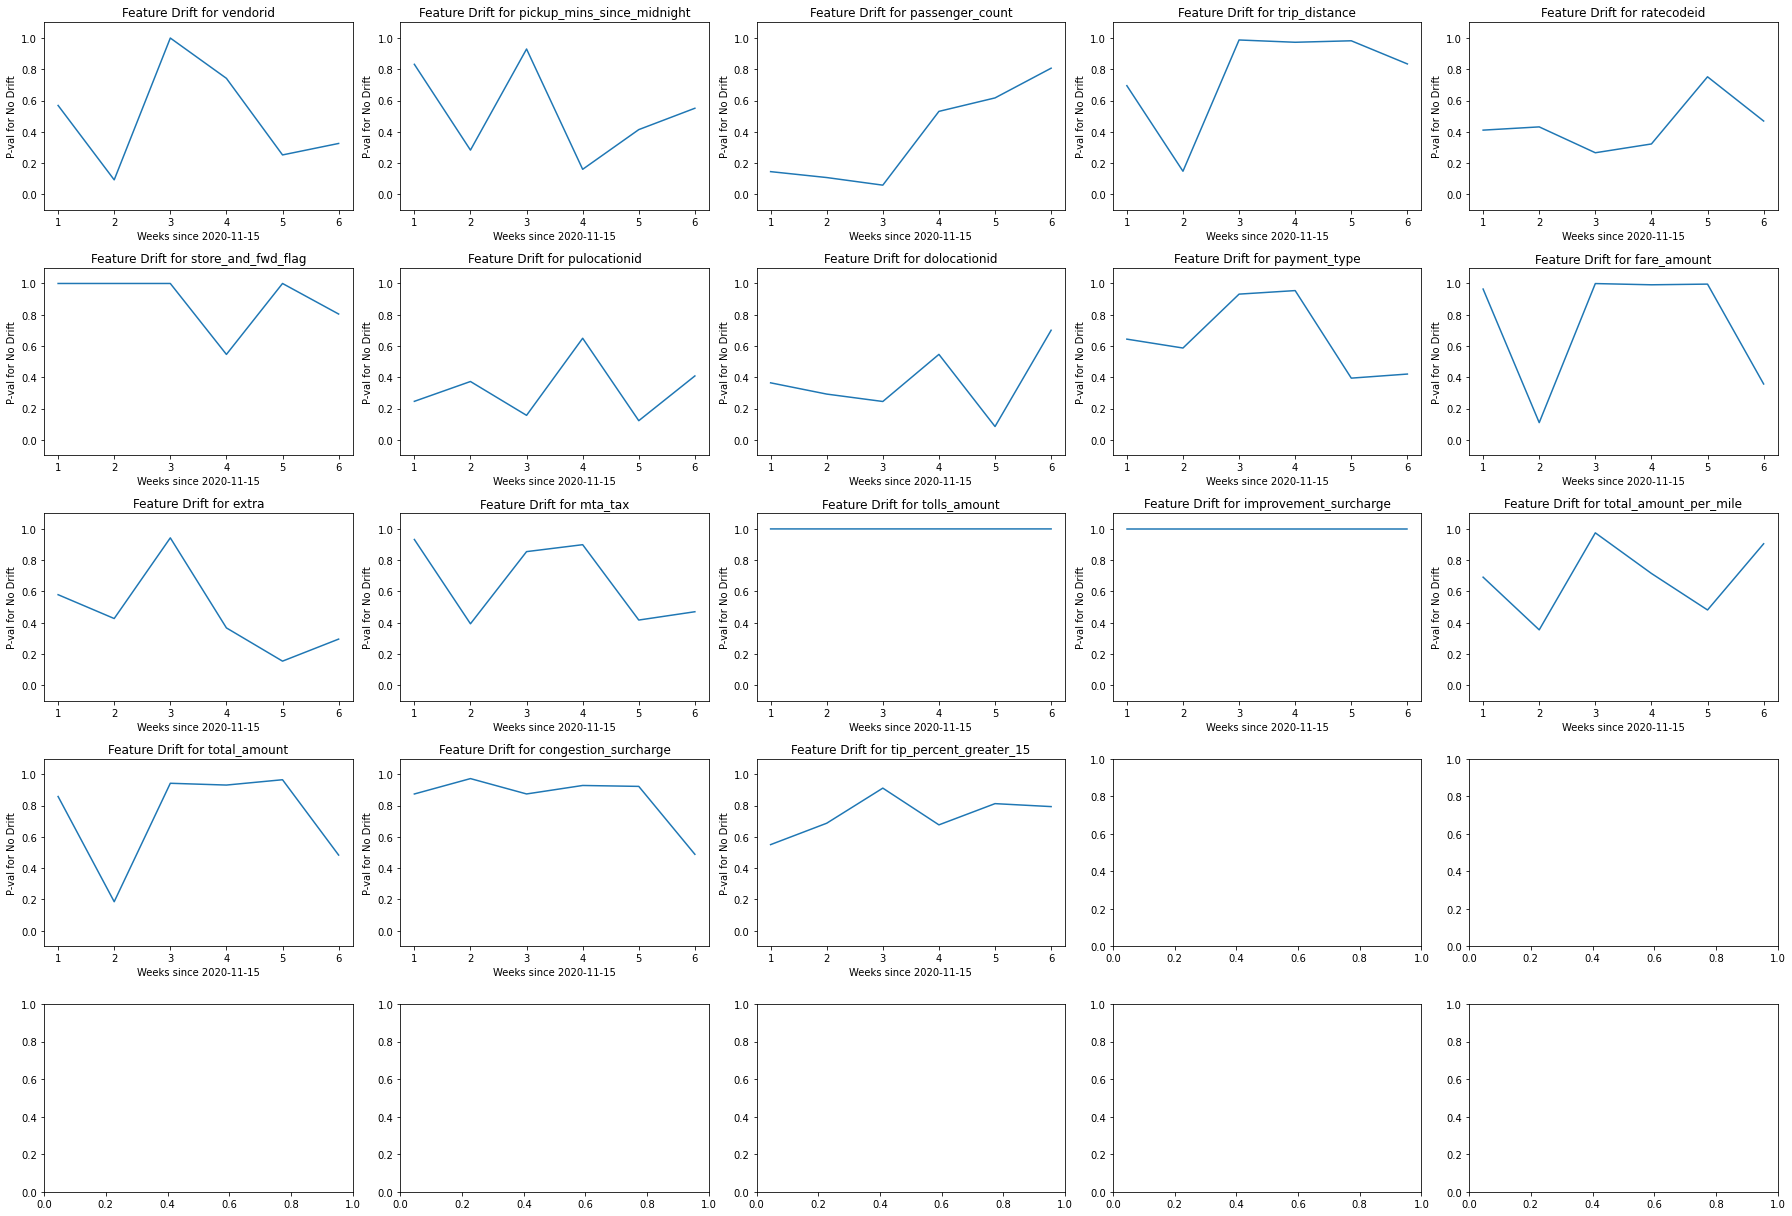

In [10]:
data_cols = [
       'vendorid',
       'pickup_mins_since_midnight',
       'passenger_count',
       'trip_distance',
       'ratecodeid',
       'store_and_fwd_flag',
       'pulocationid',
       'dolocationid',
       'payment_type',
       'fare_amount',
       'extra',
       'mta_tax',
       'tolls_amount',
       'improvement_surcharge',
       'total_amount_per_mile',
       'total_amount',
       'congestion_surcharge',
       'tip_percent_greater_15']
df_data = df_sample[data_cols]
time_index_col = df_sample['tpep_pickup_datetime']
date_slices = tuple(
    date_iter_step_size(global_start_date, global_end_date))
accessor_factory_annotated = AccessorFactory(
    df_data, time_index_col, date_slices[0], date_slices[1:],
    is_continuous_annotations)

plot_feature_wise_interweek_performance(
    accessor_factory_annotated,
    TabularModel(),
    'tip_percent_greater_15')

In [11]:
'''
    depend on alibi_detect implementation of trainer for
    fast implementation of train loop
'''
from alibi_detect.models.pytorch.trainer import trainer
from torch.utils.data import TensorDataset, DataLoader

In [12]:
x_labels = (
       'vendorid',
       'pickup_mins_since_midnight',
       'passenger_count',
       'trip_distance',
       'ratecodeid',
       'store_and_fwd_flag',
       'pulocationid',
       'dolocationid',
       'payment_type',
       'fare_amount',
       'extra',
       'mta_tax',
       'tolls_amount',
       'improvement_surcharge',
       'total_amount_per_mile',
       'total_amount',
       'congestion_surcharge')
y_label = 'tip_percent_greater_15'
df_data = df_sample[list(x_labels + (y_label,))]
time_index_col = df_sample['tpep_pickup_datetime']
date_slices = tuple(
    date_iter_step_size(global_start_date, global_end_date))
accessor_factory_default = AccessorFactory(
    df_data, time_index_col, date_slices[0], date_slices[1:])
accessor_factory_annotated = AccessorFactory(
    df_data, time_index_col, date_slices[0], date_slices[1:],
    is_continuous_annotations)

model_perf_dfs = []
runtime_dfs = []

model_baseline_perf, runtime = get_drift_perf_with_runtimes(accessor_factory_default,
    OutputClassifierAccuracyBaselineModel(RandomForestClassifier()), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('AccuracyBaseline', model_baseline_perf, date_slices))
runtime_dfs.append(create_df_model_performance('AccuracyBaseline', runtime, date_slices))

# TODO: verify with Shreya that 'micro' arguments to sklearn f1_score
# is what works for this binary classifier case.
model_baseline_perf, runtime = get_drift_perf_with_runtimes(accessor_factory_default,
    OutputClassifierF1ScoreBaselineModel(RandomForestClassifier()), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('F1ScoreBaseline', model_baseline_perf, date_slices))
runtime_dfs.append(create_df_model_performance('F1ScoreBaseline', runtime, date_slices))

drift_perf, runtime = get_drift_perf_with_runtimes(
    accessor_factory_annotated, TabularModel(), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('TabularModel', drift_perf, date_slices))
runtime_dfs.append(create_df_model_performance('TabularModel', runtime, date_slices))

drift_perf, runtime = get_drift_perf_with_runtimes(
    accessor_factory_default, CVMModel(), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('CVMModel', drift_perf, date_slices))
runtime_dfs.append(create_df_model_performance('CVMModel', runtime, date_slices))

drift_perf, runtime = get_drift_perf_with_runtimes(
    accessor_factory_default, FETModel(), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('FETModel', drift_perf, date_slices))
runtime_dfs.append(create_df_model_performance('FETModel', runtime, date_slices))

drift_perf, runtime = get_drift_perf_with_runtimes(
    accessor_factory_default, MMDModel(), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('MMDModel', drift_perf, date_slices))
runtime_dfs.append(create_df_model_performance('MMDModel', runtime, date_slices))

proj = nn.Sequential(
    nn.Linear(len(x_labels),  10),
    nn.Linear(10, 10),
)
kernel = DeepKernel(proj, eps=0.01)
drift_perf, runtime = get_drift_perf_with_runtimes(
    accessor_factory_default, LearnedKernelModel(kernel), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('LearnedKernelModel', drift_perf, date_slices))
runtime_dfs.append(create_df_model_performance('LearnedKernelModel', runtime, date_slices))

model = nn.Sequential(
    nn.Linear(len(x_labels), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)
drift_perf, runtime = get_drift_perf_with_runtimes(
    accessor_factory_default, ClassifierDriftModel(model), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('ClassifierDriftModel', drift_perf, date_slices))
runtime_dfs.append(create_df_model_performance('ClassifierDriftModel', runtime, date_slices))

drift_perf, runtime = get_drift_perf_with_runtimes(
    accessor_factory_default, SpotTheDiffModel(), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('SpotTheDiffModel', drift_perf, date_slices))
runtime_dfs.append(create_df_model_performance('SpotTheDiffModel', runtime, date_slices))

model = nn.Sequential(
    nn.Linear(len(x_labels), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)
def train_model_function(model, train_x, train_y):
    x_tensor = torch.tensor(train_x, dtype=torch.float)
    y_tensor = torch.tensor(train_y, dtype=torch.long)
    dataloader = DataLoader(TensorDataset(x_tensor, y_tensor))
    trainer(model, nn.CrossEntropyLoss(), dataloader, 'cpu', verbose=0)
drift_perf, runtime = get_drift_perf_with_runtimes(
    accessor_factory_default, ClassifierUncertaintyModel(model, train_model_function), x_labels, y_label)
model_perf_dfs.append(create_df_model_performance('ClassifierUncertaintyModel', drift_perf, date_slices))
runtime_dfs.append(create_df_model_performance('ClassifierUncertaintyModel', runtime, date_slices))

pd.concat(model_perf_dfs).to_csv('ModelPerfAggregated.csv')
pd.concat(runtime_dfs).to_csv('ModelRuntimeAggregated.csv')

No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
